# Import libs

In [1]:
# Import some stuff
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl

from datetime import datetime
from dateutil.parser import parse
import pandas as pd


from pandas.io.json import json_normalize
from PIL import Image
from wordcloud import STOPWORDS, WordCloud

# SET A SEED
seed = 320


# We will need this at some point....
import geopandas as gp

In [2]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

In [3]:
# load .env variable
base_dir = 'D:\Documentos\GitHub\CityBlender'
dotenv_file = os.path.join(base_dir, '.env')


if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

In [4]:
# create a new MongoDB Client
db_client = MongoClient(str(db_uri))

# If it's ok it should return a 1.0
db_client.london.command("serverStatus")['ok']

1.0

In [5]:
# choose a database to connect to (.london)
db_london = db_client.london

# choose a collection
db_london_events = db_london['events']
db_london_artist = db_london['artists']

In [6]:
# lookup all the documents in a collection
db_london_events.find()

## EOD

In [7]:
events = pd.DataFrame(list(db_london_events.find({})))

In [8]:
events.columns

Index(['_id', 'artists', 'date', 'datetime', 'datetime_source', 'foursquare',
       'id', 'lastfm', 'location', 'name', 'popularity', 'spotify', 'time',
       'type', 'url', 'venue'],
      dtype='object')

### For instance in the first row there are 3 events

In [9]:
# Put this in the date fomrat
events['date'] = [(datetime.strptime(events['date'][x], '%Y-%m-%d')) for x in range(len(events['date']))]

# Convert the dates into day name
events['date_name'] = [(events['date'][x].strftime("%A")) for x in range(len(events['date']))]

# Lat & Long
events['lat'] = [(events['location'][x]['lat']) for x in range(len(events['location']))]
events['lng'] = [(events['location'][x]['lng']) for x in range(len(events['location']))]

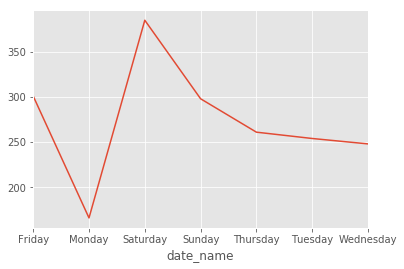

In [10]:
events.groupby('date_name').count()['_id'].plot()

## Spotify

In [11]:
for key in events['spotify'][0]:
  print(key)

genres
popularity
popularity_median
popularity_min
popularity_max
popularity_pvariance
followers
followers_sum
danceability
danceability_median
danceability_min
danceability_max
danceability_pvariance
energy
energy_median
energy_min
energy_max
enery_pvariance
key
key_mode
key_min
key_max
loudness
loudness_median
loudness_min
loudness_max
loudness_pvariance
mode
mode_mode
speechiness
speechiness_median
speechines_min
speechines_max
speechines_pvariance
acousticness
acousticness_median
acousticness_min
acousticness_max
acousticness_pvariance
instrumentalness
instrumentalness_median
instrumentalness_min
instrumentalness_max
instrumentalness_pvariance
liveness
liveness_median
liveness_min
liveness_max
liveness_pvariance
valence
valence_median
valence_min
valence_max
valence_pvariance
tempo
tempo_median
tempo_min
tempo_max
tempo_pvariance
duration_ms
duration_ms_mean
duration_ms_min
duration_ms_max
duration_ms_pvariance
time_signature
time_signature_mode


In [12]:
list1 = [
    'popularity_pvariance',
    'danceability_pvariance',
    'enery_pvariance',
    'speechines_pvariance',
    'acousticness_pvariance',
    'instrumentalness_pvariance',
    'liveness_pvariance',
    'valence_pvariance',
    'duration_ms_pvariance',
    'tempo_pvariance',]

In [13]:
list_of_bars = [
    'popularity_median',
    'followers_sum',
    'danceability_median',
    'energy_median',
    'key_mode',
    'loudness_median',
    'mode_mode',
    'speechiness_median',
    'acousticness_median',
    'instrumentalness_median',
    'liveness_median',
    'valence_median',
    'duration_ms_mean',
    'time_signature_mode']

In [14]:
def make_vars(db = events, dictionary = 'spotify', var = 'popularity_median'):
    lista_nueva = []
    # Make this for the desired variable
    for i in range(len(db[dictionary])):
        # If there is nothing in the spotify dictionary, make Nan value
        if type(db[dictionary][i]) == float:
            lista_nueva.append(np.nan)

        else:
            # print(db[dictionary][i][var])
            lista_nueva.append(db[dictionary][i][var])
            
    # Integrate all the stuff
    db[var] =   lista_nueva      


In [15]:
for i in list_of_bars:
    # print(i)
    make_vars(db = events, dictionary = 'spotify', var = i)

# Plotly Stuff

In [16]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

plotly.tools.set_credentials_file(username='cohenjota', api_key='I6zLnEN42oNTpZv36icg')

## City Level

In [17]:
import fiona
from mpl_toolkits.basemap import Basemap   
import pandas as pd
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from descartes import PolygonPatch

In [18]:
shp = "D:/Documentos/GitHub/cityBlender/data-analysis/03_GIS/London_proj.shp"

In [19]:
shp = fiona.open(shp) # Cologne districts shapefile
coords = shp.bounds         # Extract the bound coordinates from the shapefile
shp.close()

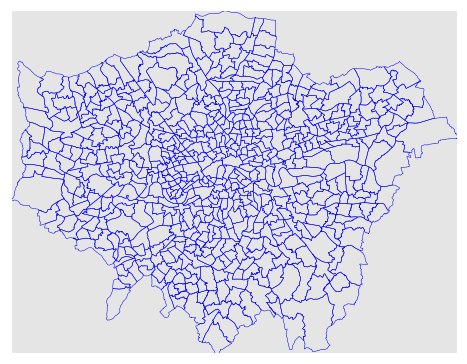

In [20]:
fig, ax = plt.subplots(figsize=(8,8))  # figure and axis objects 
m = Basemap(
    projection='tmerc', ellps='WGS84', # set transverse mercator proj. and ellipsoid
    lon_0=(coords[0] + coords[2]) / 2, # longitude center
    lat_0=(coords[1] + coords[3]) / 2, # latitude center 
    llcrnrlon=coords[0],    # left lower corner 
    llcrnrlat=coords[1],
    urcrnrlon=coords[2],    # upper right corner 
    urcrnrlat=coords[3] ,
    resolution='c',  suppress_ticks=True
    )


m.readshapefile("D:/Documentos/GitHub/cityBlender/data-analysis/03_GIS/London_proj",
                name='london', drawbounds=True, color='blue')

plt.show()

In [111]:
events

_id  \
0     5af9c6dc0cc9ab0004e227d1   
1     5af9c6de0cc9ab0004e227d3   
2     5af9c6e30cc9ab0004e227d6   
3     5af9c6e50cc9ab0004e227d8   
4     5af9c6eb0cc9ab0004e227db   
5     5af9c6ed0cc9ab0004e227dd   
6     5af9c6ef0cc9ab0004e227df   
7     5af9c6f00cc9ab0004e227e1   
8     5af9c6f40cc9ab0004e227e4   
9     5af9c6f60cc9ab0004e227e6   
10    5af9c6f80cc9ab0004e227e8   
11    5af9c6fa0cc9ab0004e227ea   
12    5af9c6fc0cc9ab0004e227ec   
13    5af9c6fe0cc9ab0004e227ee   
14    5af9c7040cc9ab0004e227f2   
15    5af9c7060cc9ab0004e227f4   
16    5af9c70a0cc9ab0004e227f7   
17    5af9c70c0cc9ab0004e227f9   
18    5af9c70f0cc9ab0004e227fb   
19    5af9c7110cc9ab0004e227fd   
20    5af9c7130cc9ab0004e227ff   
21    5af9c7190cc9ab0004e22802   
22    5af9c71b0cc9ab0004e22804   
23    5af9c71d0cc9ab0004e22806   
24    5af9c71f0cc9ab0004e22808   
25    5af9c7220cc9ab0004e2280b   
26    5af9c7260cc9ab0004e2280e   
27    5af9c7280cc9ab0004e22810   
28    5af9c72a0cc9ab0004e22812   
29    5af9c72c0cc9ab0004e22814   
30    5af9c7310cc9ab0004e22817   
31    5af9c7330cc9ab0004e22819   
32    5af9c7340cc9ab0004e2281b   
33    5af9c7360cc9ab0004e2281d   
34    5af9c7380cc9ab0004e2281e   
35    5af9c73a0cc9ab0004e22820   
36    5af9c73c0cc9ab0004e22822   
37    5af9c7400cc9ab0004e22825   
38    5af9c7420cc9ab0004e22827   
39    5af9c7510cc9ab0004e22831   
40    5af9c7550cc9ab0004e22834   
41    5af9c7560cc9ab0004e22836   
42    5af9c75b0cc9ab0004e22839   
43    5af9c75d0cc9ab0004e2283b   
44    5af9c7600cc9ab0004e2283e   
45    5af9c7630cc9ab0004e22841   
46    5af9c7650cc9ab0004e22843   
47    5af9c7670cc9ab0004e22845   
48    5af9c76b0cc9ab0004e22848   
49    5af9c76f0cc9ab0004e2284b   
50    5af9c7710cc9ab0004e2284d   
51    5af9c7730cc9ab0004e2284f   
52    5af9c7770cc9ab0004e22853   
53    5af9c7790cc9ab0004e22855   
54    5af9c77c0cc9ab0004e22856   
55    5af9c77e0cc9ab0004e22858   
56    5af9c7800cc9ab0004e2285a   
57    5af9c7830cc9ab0004e2285c   
58    5af9c7850cc9ab0004e2285f   
59    5af9c7880cc9ab0004e22861   
60    5af9c78a0cc9ab0004e22863   
61    5af9c78b0cc9ab0004e22865   
62    5af9c78f0cc9ab0004e22867   
63    5af9c7910cc9ab0004e22869   
64    5af9c7950cc9ab0004e2286d   
65    5af9c7990cc9ab0004e22870   
66    5af9c79b0cc9ab0004e22872   
67    5af9c79f0cc9ab0004e22875   
68    5af9c7a10cc9ab0004e22877   
69    5af9c7a40cc9ab0004e2287a   
70    5af9c7a60cc9ab0004e2287c   
71    5af9c7aa0cc9ab0004e2287e   
72    5af9c7ac0cc9ab0004e22880   
73    5af9c7af0cc9ab0004e22882   
74    5af9c7b40cc9ab0004e22885   
75    5af9c7b60cc9ab0004e22887   
76    5af9c7b80cc9ab0004e22889   
77    5af9c7bd0cc9ab0004e2288c   
78    5af9c7bf0cc9ab0004e2288e   
79    5af9c7c20cc9ab0004e2288f   
80    5af9c7c40cc9ab0004e22891   
81    5af9c7c60cc9ab0004e22893   
82    5af9c7ca0cc9ab0004e22896   
83    5af9c7cc0cc9ab0004e22898   
84    5af9c7ce0cc9ab0004e22899   
85    5af9c7d00cc9ab0004e2289b   
86    5af9c7d60cc9ab0004e2289f   
87    5af9c7d80cc9ab0004e228a1   
88    5af9c7da0cc9ab0004e228a3   
89    5af9d770985cfc00044f8168   
90    5af9d771985cfc00044f816a   
91    5af9d773985cfc00044f816c   
92    5af9d775985cfc00044f816e   
93    5af9d778985cfc00044f8171   
94    5af9d77a985cfc00044f8174   
95    5af9d77b985cfc00044f8175   
96    5af9d77d985cfc00044f8176   
97    5af9d77f985cfc00044f8179   
98    5af9d781985cfc00044f817b   
99    5af9d783985cfc00044f817d   
100   5af9d785985cfc00044f817f   
101   5af9d787985cfc00044f8181   
102   5af9d78c985cfc00044f8184   
103   5af9d78e985cfc00044f8186   
104   5af9d790985cfc00044f8188   
105   5af9d794985cfc00044f818b   
106   5af9d797985cfc00044f818d   
107   5af9d799985cfc00044f818f   
108   5af9d79b985cfc00044f8191   
109   5af9d79d985cfc00044f8192   
110   5af9d7a1985cfc00044f8195   
111   5af9d7a7985cfc00044f8199   
112   5af9d7a9985cfc00044f819b   
113   5af9d7b0985cfc00044f81a0   
114   5af9d7b2985cfc00044f81a2   
115   5af9d7b4985cfc00044f81a4   
116   5af9d7b8985cfc00044f81a7   
117   5af9d7ba9

In [22]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_name': [ward['NAME'] for ward in m.london_info]})

df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, 
     mapped_y in zip(events['lng'], events['lat'])])

gigs = MultiPoint(list(map_points.values))

wards_polygon = MultiPolygon(list(df_map['poly'].values))

#ldn_points = filter(wards_polygon.contains, plaque_points)

In [23]:
type(gigs)

shapely.geometry.multipoint.MultiPoint

In [27]:
# IMPORT STUFF
import shapefile
import shapely, shapely.geometry


In [67]:
shapelytogeojson = shapely.geometry.mapping

In [68]:
geoj = shapelytogeojson(gigs)

In [110]:
events.to_csv('test.csv', sep = '^')

In [106]:
# CREATE YOUR SHAPELY TEST INPUT
TEST_SHAPELYSHAPE = shapely.geometry.Polygon([(133,822),(422,644),(223,445),(921,154)])

#########################################################
################## END OF USER INPUT ####################
#########################################################

# DEFINE/COPY-PASTE THE SHAPELY-PYSHP CONVERSION FUNCTION
def shapely_to_pyshp(shapelygeom):
    # first convert shapely to geojson
    try:
        shapelytogeojson = shapely.geometry.mapping
    except:
        import shapely.geometry
        shapelytogeojson = shapely.geometry.mapping
    geoj = shapelytogeojson(shapelygeom)
    # create empty pyshp shape
    record = shapefile._Shape()
    # set shapetype
    if geoj["type"] == "Null":
        pyshptype = 0
    elif geoj["type"] == "Point":
        pyshptype = 1
    elif geoj["type"] == "LineString":
        pyshptype = 3
    elif geoj["type"] == "Polygon":
        pyshptype = 5
    elif geoj["type"] == "MultiPoint":
        pyshptype = 8
    elif geoj["type"] == "MultiLineString":
        pyshptype = 3
    elif geoj["type"] == "MultiPolygon":
        pyshptype = 5
    record.shapeType = pyshptype
    # set points and parts
    if geoj["type"] == "Point":
        record.points = geoj["coordinates"]
        record.parts = [0]
    elif geoj["type"] in ("MultiPoint","Linestring"):
        record.points = geoj["coordinates"]
        record.parts = [0]
    elif geoj["type"] in ("Polygon"):
        record.points = geoj["coordinates"][0]
        record.parts = [0]
    elif geoj["type"] in ("MultiPolygon","MultiLineString"):
        index = 0
        points = []
        parts = []
        for eachmulti in geoj["coordinates"]:
            points.extend(eachmulti[0])
            parts.append(index)
            index += len(eachmulti[0])
        record.points = points
        record.parts = parts
    return record

# WRITE TO SHAPEFILE USING PYSHP
shapewriter = shapefile.Writer()
shapewriter.field("field1")
# step1: convert shapely to pyshp using the function above
converted_shape = shapely_to_pyshp(TEST_SHAPELYSHAPE)
# step2: tell the writer to add the converted shape
shapewriter._shapes.append(converted_shape)
# add a list of attributes to go along with the shape
shapewriter.record(["empty record"])
# save it
shapewriter.save("test_shapelytopyshp.shp")

In [44]:
wards_polygon

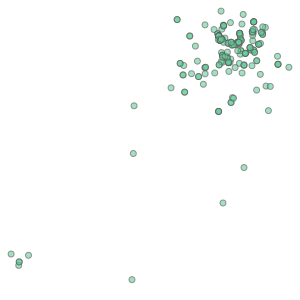

In [45]:
gigs[0:200]

In [46]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

<Figure size 432x288 with 0 Axes>

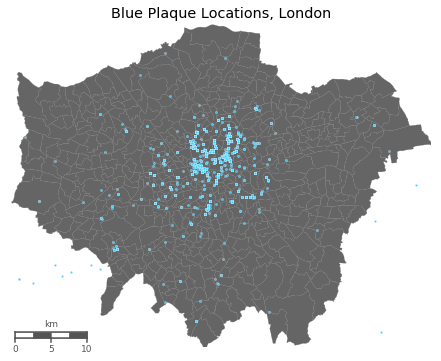

In [47]:
# draw ward patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in gigs],
    [geom.y for geom in gigs],
    5, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Blue Plaque Locations', zorder=3)

# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values,
                                  match_original=True))

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.title("Blue Plaque Locations, London")
plt.tight_layout()

# this will set the image width to 722px at 100dpi
fig.set_size_inches(7.22, 5.25)
#plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()

# Make a density map

In [48]:
def points_per_poly(poly, points):
    poly = prep(poly)
    return int(len(list(filter(poly.contains, points))))

In [49]:
points_per_poly(wards_polygon[2], gigs)

0

In [50]:
count = []
for i in range(len(wards_polygon)):
    #print(i)
    count.append(points_per_poly(wards_polygon[i], gigs))
    

df_map['count'] = count

In [51]:
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

In [52]:
from pysal.esda.mapclassify import Natural_Breaks as nb

In [53]:
# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

In [54]:
jenks_labels = ["<= %0.1f/km$^2$(%s wards)" % (b, c) for b, c in zip(
    breaks.bins, breaks.counts)]
jenks_labels.insert(0, 'No plaques (%s wards)' % len(df_map[df_map['density_km'].isnull()]))

<Figure size 432x288 with 0 Axes>

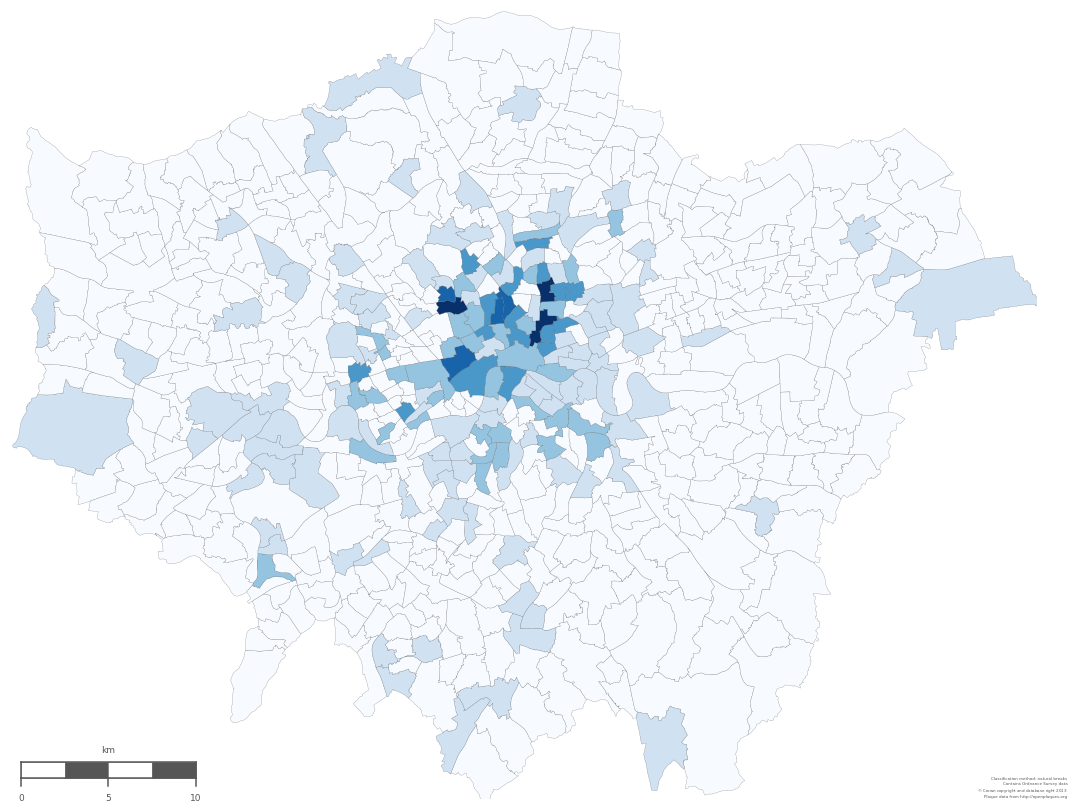

In [55]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Add a colour bar
#cb = colorbar_index(ncolors=len(jenks_labels), 
#                    cmap=cmap, shrink=0.5, labels=jenks_labels)

#cb.ax.tick_params(labelsize=6)

# Show highest densities, in descending order
#highest = '\n'.join(
#    value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
#highest = 'Most Dense Wards:\n\n' + highest

# Subtraction is necessary for precise y coordinate alignment
#details = cb.ax.text(
#    -1., 0 - 0.007,
#    highest,
#    ha='right', va='bottom',
#    size=5,
#    color='#555555')

# Bin method, copyright and source data info
smallprint = ax.text(
    1.03, 0,
    'Classification method: natural breaks\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2013\nPlaque data from http://openplaques.org',
    ha='right', va='bottom',
    size=4,
    color='#555555',
    transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.08, coords[1] + 0.015,
    coords[0], coords[1],
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
# this will set the image width to 722px at 100dpi
plt.tight_layout()
fig.set_size_inches(15 , 15)
#plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()

In [56]:
list_of_wards = df_map[['ward_name', 'count']].sort_values('count', axis=0, ascending=False)

In [57]:
len(df_map[['ward_name', 'count']].sort_values('count', axis=0, ascending=False))

625

In [58]:
625/10

62.5

In [59]:
df_map[['ward_name', 'count']].sort_values('count', axis=0, ascending=False)[0:15]

ward_name  count
504  Camden Town with Primrose Hill    144
549                      Haggerston    131
484                        West End    126
554                         Dalston    116
478                     St. James's     81
535                      St. Mary's     62
543                       Barnsbury     62
514                      Haverstock     52
245                      Cathedrals     38
624                  City of London     34
523             Bethnal Green North     34
534                      Caledonian     32
537                   Highbury East     31
264                       New Cross     30
563                 Hackney Central     29

In [60]:
import plotly.figure_factory as ff

In [61]:
hist_data = [list(list_of_wards['count'])]
group_labels = ['Count of Gigs']

fig = ff.create_distplot(hist_data, group_labels)
py.iplot(fig, filename='Basic Distplot')

In [62]:
list_for_bar = list_of_wards[0:30]

In [63]:
list_for_bar.set_index('ward_name', inplace = True)

In [64]:
list_for_bar = list_for_bar.transpose()

In [65]:
data = [
    go.Bar(
        x=list_for_bar['ward_name'], # assign x as the dataframe column 'x'        
        y=list_for_bar['count'],
        marker=dict(
            color='rgba(50, 171, 96, 0.7)',
            line=dict(
                color='rgba(50, 171, 96, 1.0)',
                width=2)
        )
    )
]


layout = go.Layout(
    title='Amount of Gigs per Ward', 
    showlegend=False,
     xaxis=dict(
        autorange=True, tickangle = 45)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='wards-bar')

KeyError: 'ward_name'

In [ ]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd

In [ ]:
shp = "D:/Documentos/GitHub/cityBlender/data-analysis/03_GIS/London_proj.shp"

# Read data
wards = gpd.read_file(shp)

In [ ]:
wards.crs

In [ ]:
geometry = [Point(xy) for xy in zip(events['lng'], events['lat'])]
#df = df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(events, crs=crs, geometry=geometry)

In [ ]:
join = gpd.sjoin(gdf, wards, how="inner", op="within")

In [ ]:
join

In [ ]:
BOROUGHs = pd.DataFrame(join.groupby('BOROUGH').count()['_id'].sort_values(ascending = False)[0:12])

In [ ]:
BOROUGHs['BOROUGH'] = BOROUGHs.index

In [ ]:
data = [
    go.Bar(
        x=BOROUGHs['BOROUGH'], # assign x as the dataframe column 'x'        
        y=BOROUGHs['_id'],
        marker=dict(
            color='rgba(50, 171, 96, 0.7)',
            line=dict(
                color='rgba(50, 171, 96, 1.0)',
                width=2)
        )
    )
]


layout = go.Layout(
    title='Amount of Gigs per boroughs', 
    showlegend=False,
     xaxis=dict(
        autorange=True, tickangle = 45)
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='BOROUGHs-bar')

In [112]:
# Make a function to subset the genre depending on which dataset
def subset_by_genre(db, lib = 'spotify', words = 'reggae'):
    return db[db[lib].astype(str).str.contains(words, case=False)]

#create a genre compiling function
def genre_df_compiler(genreName, db = events):
    firstEventsdf = subset_by_genre(db, lib='spotify',words = genreName)
    secondEventsdf = subset_by_genre(db, lib='lastfm',words = genreName)
    allEventsdf = "all"+genreName+"Events" 
    allEventsdf = pd.concat([firstEventsdf, secondEventsdf])
    allEventsdf = allEventsdf.drop_duplicates(subset='_id', keep='last')
    return(allEventsdf)

NameError: name 'londonEventsdfNoNan' is not defined